In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

In [54]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()

In [4]:
lonMin = (float)(config['REGEION']['LON_MIN'])
lonMax = (float)(config['REGEION']['LON_MAX'])

latMin = (float)(config['REGEION']['LAT_MIN'])
latMax = (float)(config['REGEION']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['HEATMAP']['INCR_STEP'])
incrRes = (int)(config['HEATMAP']['INCR_RES'])

-120.0 31.0
-117.0 34.5


In [5]:
#compute KDE from this heat map
#kde takes two dimensional data
#replace every point from the heatmap to corresponding middle value of coordinate
#first get the boundar array
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]

In [6]:
#will return the LON and LAT from index
#scans through boundary array and gives corresponding LON and LAT
def get_lon_lat_from_index(idxVal):
    for boundary in boundaryArray:
        if(idxVal == boundary[hMUtil.FLAT_INDEX_INDEX]):
            return boundary[hMUtil.LON_MIN_INDEX], boundary[hMUtil.LON_MAX_INDEX],\
                    boundary[hMUtil.LAT_MIN_INDEX], boundary[hMUtil.LAT_MAX_INDEX]
        
#more like a inverse function of heat map
def compute_points_from_heatmap(hMArr):
    #iterate through every grid 
    #to get  the LON and LAT coordinates
    lonArr = []
    latArr = []
    for hMGridNum in range(hMArr.shape[0]):
        #get min max boundary
        retLonMin,retLonMax,retLatMin,retLatMax = get_lon_lat_from_index(hMGridNum)
        #compute its center
        retLonCen,retLatCen = hMUtil.compute_mid_point(retLonMin,retLonMax,retLatMin,retLatMax)

        #make temporary list
        tempLonArr = [retLonCen]*int(hMArr[hMGridNum])
        tempLatArr = [retLatCen]*int(hMArr[hMGridNum])

        #append into corresponding list
        lonArr.extend(tempLonArr)
        latArr.extend(tempLatArr)

    lonArrNP = np.array(lonArr)
    latArrNP = np.array(latArr)

    lonArrNP = np.reshape(lonArrNP,(lonArrNP.shape[0],1))
    latArrNP = np.reshape(latArrNP,(latArrNP.shape[0],1))

    retVal = np.hstack((lonArrNP, latArrNP))
    return retVal

In [7]:
# dummyHeatMapVal = np.zeros(yearlyHeatMapVal.shape)
# dummyHeatMapVal[0] = 5
# xTrain = compute_points_from_heatmap(dummyHeatMapVal)
#load the yearly heatmap file

yearlyHeatMapFile = "../Data/AIS_0117_1217_31_M120_345_M117/YearlyHM/YearlyHM.npy"
yearlyHeatMapVal = np.load(yearlyHeatMapFile)

xTrainYearly = compute_points_from_heatmap(yearlyHeatMapVal)
print(xTrainYearly.shape)

(244097, 2)


In [8]:
xy = hMUtil.compute_xy_for_kde(lonMin, lonMax, latMin, latMax, increStep, incrRes)

(1050, 2)


In [9]:
from sklearn.neighbors.kde import KernelDensity
kDEYearly = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xTrainYearly)
yearlyKDENP = np.exp(kDEYearly.score_samples(xy))

In [10]:
print(yearlyKDENP.shape)
print(np.sum(yearlyKDENP))

(1050,)
97.83727835489806


In [11]:
yearlyKDENPImg = np.reshape(yearlyKDENP,(verticalAxis.shape[0],horizontalAxis.shape[0]))
yearlyKDENPImg = np.flip(yearlyKDENPImg,axis=0)

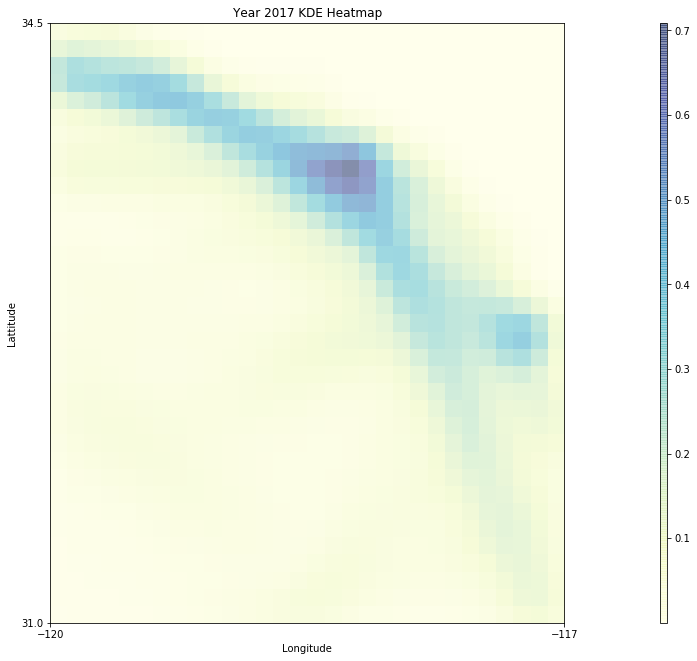

In [28]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8.5

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.01, 0.01, 0.96, 0.98])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
ax1.set_title('Year 2017 KDE Heatmap')
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
# ax1.imshow()
iMShowHandler = ax1.imshow(yearlyKDENPImg,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax],alpha = 0.5)

ax2 = fig.add_axes([0.98, 0.01, 0.01, 0.98])
fig.colorbar(iMShowHandler,ax2)

In [34]:
#divide each pixel by sum to get the probability distribution
yearlyHMNorm = yearlyKDENP/np.sum(yearlyKDENP)

In [35]:
print(np.sum(yearlyHMNorm))

0.9999999999999999


In [38]:
#read heatmaps corresponding to individual hour data
hourlyHMDir = "../Data/AIS_0117_1217_31_M120_345_M117/HourlyOnceHM/"
hMHourData = []
for i in range(8760):
    hMFile = hourlyHMDir + str(i) + '.npy'
    hMHourData.append(np.load(hMFile))

In [40]:
#now lets get yearly corresponding probabilities
sumOfProbYearly = []
for hM in hMHourData:
    #take instance of 1 particular ship
    #we multiply corresponding probabilities
    tempHM = hM > 0
    sumOfProbYearly.append(np.sum(np.multiply(yearlyHMNorm,tempHM)))

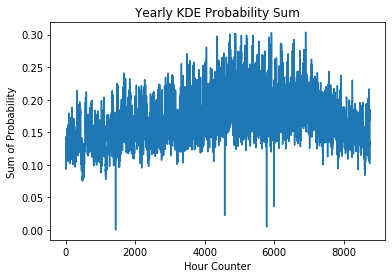

In [87]:
plt.plot(sumOfProbYearly)
plt.xlabel("Hour Counter")
plt.ylabel("Sum of Probability")
plt.title("Yearly KDE Probability Sum")
plt.savefig('YearlyKDEProbSum.png')

In [42]:
sumOfProbYearlyNP = np.array(sumOfProbYearly)
print(np.mean(sumOfProbYearlyNP))
print(np.sum(sumOfProbYearlyNP))

0.1658986476666298
1453.272153559677


In [43]:
monthlyHMDir = "../Data/AIS_0117_1217_31_M120_345_M117/MonthlyHM/"

#12 elements for 12 months
monthlyKDENP = []

for i in range(12):
    monthlyHMFile = monthlyHMDir + str(i) + '.npy'
    monthHMVal = np.load(monthlyHMFile)
    xTrainMonthly = compute_points_from_heatmap(monthHMVal)
    
    kDEMonthly = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xTrainMonthly)
    monthlyKDENP.append(np.exp(kDEMonthly.score_samples(xy)))

In [45]:
monthKDEMin = []
monthKDEMax = []
for monthKDE in monthlyKDENP:
    monthKDEMin.append(np.min(monthKDE))
    monthKDEMax.append(np.max(monthKDE))

In [92]:
monthKDEMinVal = min(monthKDEMin)
monthKDEMaxVal = max(monthKDEMax)
print(monthKDEMinVal)
print(monthKDEMaxVal)

4.0029167604593004e-29
1.0786904921797704


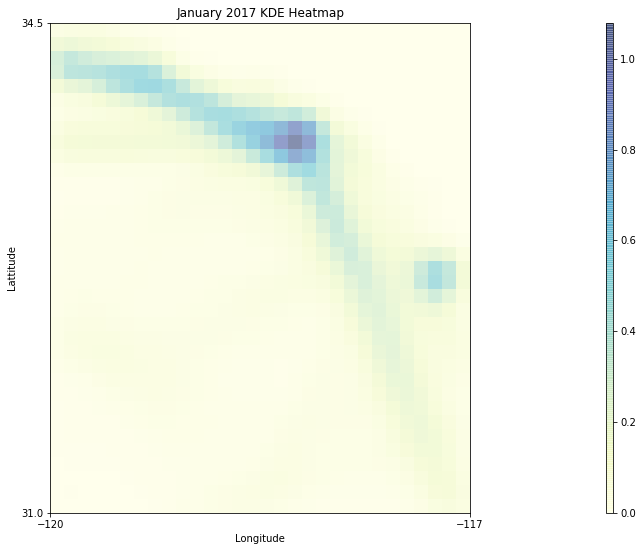

In [99]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8.5

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.01, 0.10, 0.94, 0.8])
ax2 = fig.add_axes([0.96, 0.10, 0.01, 0.8])

def animate(monthIndex):
    
    monthlyKDENPImg = np.reshape(monthlyKDENP[monthIndex],(verticalAxis.shape[0],horizontalAxis.shape[0]))
    monthlyKDENPImg = np.flip(monthlyKDENPImg,axis=0)

    titleStr = timeUtils.monthNames[monthIndex] +' 2017 KDE Heatmap'

    ax1.cla()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])
    iMShowHandler = ax1.imshow(monthlyKDENPImg,cmap=plt.get_cmap('YlGnBu') \
                               ,vmin = monthKDEMinVal, vmax = monthKDEMaxVal\
                               ,extent=[lonMin,lonMax,latMin,latMax],alpha = 0.5)
    ax2.cla()
    fig.colorbar(iMShowHandler,ax2)
    
anim = animation.FuncAnimation(fig, animate,frames=12, interval=500)

In [100]:
HTML(anim.to_html5_video())

In [82]:
monthlyHMNorm = []

for monthKDE in monthlyKDENP:
    monthlyHMNorm.append((monthKDE/np.sum(monthKDE)))

In [85]:
sumOfProbMonthly = []
hourCounter = 0
for hourCounter in range(0,8760):
    monthVal = timeUtils.get_month_from_count(hourCounter)
    tempHM = hMHourData[hourCounter] > 0
    sumOfProbMonthly.append(np.sum(np.multiply(monthlyHMNorm[monthVal],tempHM)))

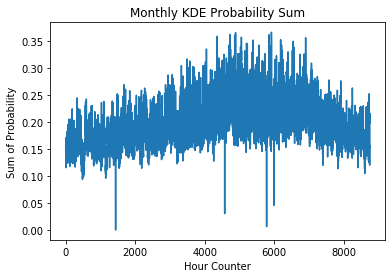

In [88]:
plt.plot(sumOfProbMonthly)
plt.xlabel("Hour Counter")
plt.ylabel("Sum of Probability")
plt.title("Monthly KDE Probability Sum")
plt.savefig('MonthlyKDEProbSum.png')

In [89]:
sumOfProbMonthlyNP = np.array(sumOfProbMonthly)
print(np.mean(sumOfProbMonthlyNP))
print(np.sum(sumOfProbMonthlyNP))

0.19742292612301118
1729.424832837578


In [90]:
weeklyHMDir = "../Data/AIS_0117_1217_31_M120_345_M117/WeeklyHM/"
weeklyKDENP = []
for i in range(0,52):
    weeklyHMFile = weeklyHMDir + str(i) + '.npy'
    weekHMVal = np.load(weeklyHMFile)
    xTrainWeekly = compute_points_from_heatmap(weekHMVal)
    
    kDEWeekly = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xTrainWeekly)
    weeklyKDENP.append(np.exp(kDEWeekly.score_samples(xy)))

In [91]:
weekKDEMin = []
weekKDEMax = []
for weekKDE in weeklyKDENP:
    weekKDEMin.append(np.min(weekKDE))
    weekKDEMax.append(np.max(weekKDE))

In [95]:
weekKDEMinVal = min(weekKDEMin)
weekKDEMaxVal = max(weekKDEMax)
print(weekKDEMinVal)
print(weekKDEMaxVal)

4.733390276514359e-31
1.3532022435012694


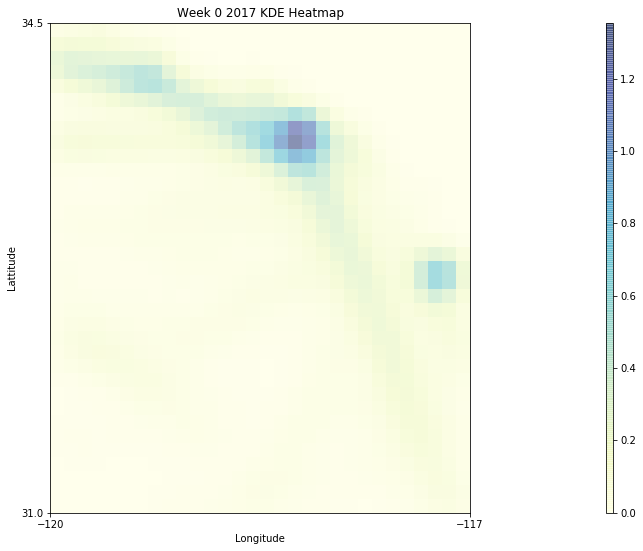

In [101]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8.5

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.01, 0.10, 0.94, 0.8])
ax2 = fig.add_axes([0.96, 0.10, 0.01, 0.8])

def animate(weekIndex):
    
    weeklyKDENPImg = np.reshape(weeklyKDENP[weekIndex],(verticalAxis.shape[0],horizontalAxis.shape[0]))
    weeklyKDENPImg = np.flip(weeklyKDENPImg,axis=0)

    titleStr = 'Week ' + str(weekIndex) +' 2017 KDE Heatmap'

    ax1.cla()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])
    iMShowHandler = ax1.imshow(weeklyKDENPImg,cmap=plt.get_cmap('YlGnBu') \
                               ,vmin = weekKDEMinVal, vmax = weekKDEMaxVal\
                               ,extent=[lonMin,lonMax,latMin,latMax],alpha = 0.5)
    ax2.cla()
    fig.colorbar(iMShowHandler,ax2)
    
anim = animation.FuncAnimation(fig, animate,frames=52, interval=500)

In [102]:
HTML(anim.to_html5_video())

In [103]:
weeklyHMNorm = []

for weekKDE in weeklyKDENP:
    weeklyHMNorm.append((weekKDE/np.sum(weekKDE)))

In [104]:
sumOfProbWeekly = []
hourCounter = 0
for hourCounter in range(0,8760):
    weekVal = hourCounter // (24*7)
    if(weekVal != 52):
        tempHM = hMHourData[hourCounter] > 0
        sumOfProbWeekly.append(np.sum(np.multiply(weeklyHMNorm[weekVal],tempHM)))

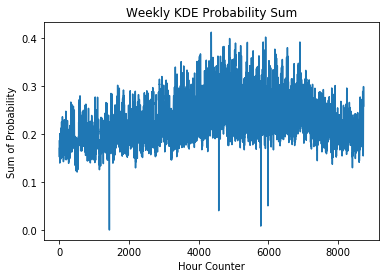

In [105]:
plt.plot(sumOfProbWeekly)
plt.xlabel("Hour Counter")
plt.ylabel("Sum of Probability")
plt.title("Weekly KDE Probability Sum")
plt.savefig('WeeklyKDEProbSum.png')

In [106]:
sumOfProbWeeklyNP = np.array(sumOfProbWeekly)
print(np.mean(sumOfProbWeeklyNP))
print(np.sum(sumOfProbWeeklyNP))

0.2239926452282236
1956.7997487137613


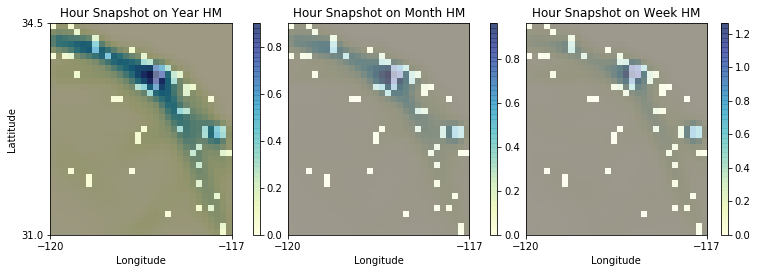

In [138]:
hourData = 6000
monthVal = timeUtils.get_month_from_count(hourData)
weekVal = hourData // (24*7)

hourImage = np.reshape(hMHourData[hourData],(verticalAxis.shape[0],horizontalAxis.shape[0]))
hourImageB = hourImage > 0
hourImageBI = np.invert(hourImageB)
hourImageBI = np.flip(hourImageB,axis=0)

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 3

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.01, 0.01, 0.29, 0.98])
ax2 = fig.add_axes([0.34, 0.01, 0.29, 0.98])
ax3 = fig.add_axes([0.67, 0.01, 0.29, 0.98])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
ax2.set_xlabel('Longitude')
ax3.set_xlabel('Longitude')

yearlyKDENPImg = np.reshape(yearlyKDENP,(verticalAxis.shape[0],horizontalAxis.shape[0]))
yearlyKDENPImg = np.flip(yearlyKDENPImg,axis=0)

monthlyKDENPImg = np.reshape(monthlyKDENP[monthVal],(verticalAxis.shape[0],horizontalAxis.shape[0]))
monthlyKDENPImg = np.flip(monthlyKDENPImg,axis=0)

weeklyKDENPImg = np.reshape(weeklyKDENP[monthVal],(verticalAxis.shape[0],horizontalAxis.shape[0]))
weeklyKDENPImg = np.flip(weeklyKDENPImg,axis=0)

ax1.set_title('Hour Snapshot on Year HM')
ax2.set_title('Hour Snapshot on Month HM')
ax3.set_title('Hour Snapshot on Week HM')
ax1.set_xticks([lonMin,lonMax])
ax2.set_xticks([lonMin,lonMax])
ax3.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
ax2.set_yticks([])
ax3.set_yticks([])

yearHandler = ax1.imshow(yearlyKDENPImg,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax])
ax1.imshow(hourImageBI,cmap=plt.get_cmap('hot'),alpha=0.4,extent=[lonMin,lonMax,latMin,latMax])

monthHandler = ax2.imshow(monthlyKDENPImg,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax],alpha = 0.5)
ax2.imshow(hourImageBI,cmap=plt.get_cmap('hot'),alpha=0.4,extent=[lonMin,lonMax,latMin,latMax])

weekHandler = ax3.imshow(weeklyKDENPImg,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax],alpha = 0.5)
ax3.imshow(hourImageBI,cmap=plt.get_cmap('hot'),alpha=0.4,extent=[lonMin,lonMax,latMin,latMax])

ax4 = fig.add_axes([0.31, 0.01, 0.01, 0.98])
ax5 = fig.add_axes([0.64, 0.01, 0.01, 0.98])
ax6 = fig.add_axes([0.96, 0.01, 0.01, 0.98])

fig.colorbar(iMShowHandler,ax4)
fig.colorbar(monthHandler,ax5)
fig.colorbar(weekHandler,ax6)